#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm, qmc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#### 2. Paths & Data loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_8"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(40, 8), y:(40,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.351365,0.099784, 0.076173,0.161989,0.36082,0.91595,0.718151,0.668977]), 9.0553832140311),  # W1
    (np.array([0.088343, 0.02128 , 0.151776, 0.018496, 0.823879, 0.721907, 0.134064, 0.2023]),  9.890404044596501), # W2
    (np.array([0.105756, 0.116724, 0.211116, 0.162702, 0.690885, 0.574863, 0.206488, 0.351411]),  9.9611043398184), # W3
    (np.array([0.171507, 0.017214, 0.084574, 0.070729, 0.938260, 0.245036, 0.212326, 0.556747]),  9.8846114223881), # W4
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(44, 8), y:(44,)


#### 4. Quick Visualization

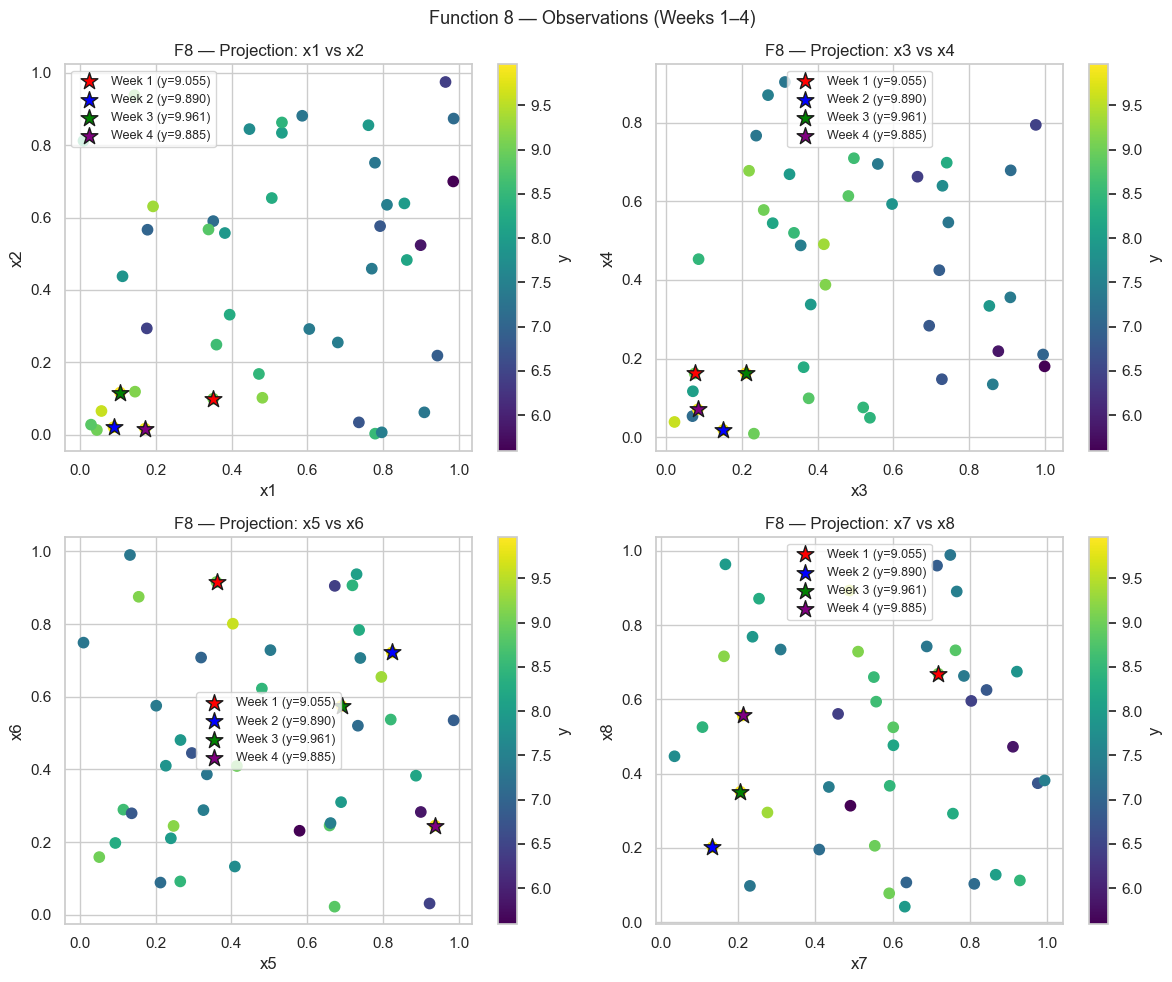

In [5]:
# --- Add Week 4 to the small multiples visualization (F8) ---

# Common color scale across subplots
vmin, vmax = float(np.min(y)), float(np.max(y))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# (x_i, x_j) pairs for 2D projections
pairs = [("x1","x2", 0,1), ("x3","x4", 2,3), ("x5","x6", 4,5), ("x7","x8", 6,7)]

# Colors and labels for weeks 1–4
colors = ["red", "blue", "green", "purple"]
labels = [
    f"Week 1 (y={week_data[0][1]:.3f})",
    f"Week 2 (y={week_data[1][1]:.3f})",
    f"Week 3 (y={week_data[2][1]:.3f})",
    f"Week 4 (y={week_data[3][1]:.3f})",
]

for ax, (lx, ly, i, j) in zip(axes.ravel(), pairs):
    # Background scatter: initial + all weeks, colored by y
    sc = ax.scatter(X[:, i], X[:, j], c=y, cmap="viridis", s=55, vmin=vmin, vmax=vmax)
    # Highlight each week's point with a star
    for (xw, yw), c, lab in zip(week_data, colors, labels):
        ax.scatter(xw[i], xw[j], c=c, s=160, marker="*", edgecolors="k", label=lab)
    ax.set_xlabel(lx); ax.set_ylabel(ly)
    ax.set_title(f"F8 — Projection: {lx} vs {ly}")
    ax.legend(loc="best", fontsize=9)
    fig.colorbar(sc, ax=ax, label="y")

plt.suptitle("Function 8 — Observations (Weeks 1–4)", fontsize=13)
plt.tight_layout()
plt.show()

##### 5. Gaussian Process Model + Adquisition

##### 5.1 Scale X (8D) and fit GP

In [6]:
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(8)*0.5, nu=2.5, length_scale_bounds=(0.02, 4.0))
    + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-5, 0.2))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=20,
    alpha=1e-10,
    random_state=0
)
gp.fit(Xz, y)
print("[F8] Fitted kernel:", gp.kernel_)


[F8] Fitted kernel: 0.75**2 * Matern(length_scale=[2.63, 4, 2.17, 4, 4, 4, 3.41, 4], nu=2.5) + WhiteKernel(noise_level=1e-05)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 4.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 4.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 4.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py

#### 5.1.b Boundary diagnostics (optional, auto-refit if stuck)

In [10]:
try:
    matern = gp.kernel_.k1.k2
    ls = np.atleast_1d(matern.length_scale)
    lb, ub = matern.length_scale_bounds
    if np.isclose(ls, lb, rtol=0, atol=1e-3).any() or np.isclose(ls, ub, rtol=0, atol=1e-3).any():
        print("[F8][WARN] length_scale at bound → refitting with wider bounds...")
        kernel_refit = (
            C(1.0, (1e-3, 1e3)) *
            Matern(length_scale=ls, nu=2.5, length_scale_bounds=(0.01, 6.0))
            + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-5, 0.3))
        )
        gp = GaussianProcessRegressor(
            kernel=kernel_refit,
            normalize_y=True,
            n_restarts_optimizer=25,
            alpha=1e-10,
            random_state=1
        )
        gp.fit(Xz, y)
        print("[F8] Re-fitted kernel:", gp.kernel_)
except Exception as e:
    print("[F8] Diagnostic skipped:", e)

[F8][WARN] length_scale at bound → refitting with wider bounds...
[F8] Re-fitted kernel: 0.914**2 * Matern(length_scale=[3.38, 6, 2.89, 6, 6, 6, 4.34, 6], nu=2.5) + WhiteKernel(noise_level=1e-05)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 6.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 6.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py

####  5.2 Trust region & candidates 

In [7]:
# LHS sampler
def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

# Bounds from initial observed range (+10% padding), clamped to [0,1]
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad * (hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad * (hi - lo), 0.0, 1.0)

# Anchor at current best (do not hardcode week index)
best_idx = np.argmax(y)          # includes weeks you've appended
anchor   = X[best_idx]

# Moderately narrow TR for refinement
L = 0.30                          # you can try 0.28 if EI gets very flat
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0, 1)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0, 1)

# Guard: if TR was shrunk too much by clipping, widen minimally
span = ub_tr - lb_tr
min_span = 1e-3
if np.any(span < min_span):
    center = 0.5 * (lb_tr + ub_tr)
    half   = np.maximum(span / 2, min_span / 2)
    lb_tr  = np.clip(center - half, 0, 1)
    ub_tr  = np.clip(center + half, 0, 1)

print("[F8] TR box:\n  lb_tr:", lb_tr, "\n  ub_tr:", ub_tr)

# Candidates: 70% TR + 30% global (8D needs volume)
N_tr, N_gl = 90_000, 40_000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=8031)
C_gl = lhs(lb,    ub,    N_gl, seed=8032)
Cands = np.vstack([C_tr, C_gl])

# (Optional) light de-dup to avoid identical rows from LHS collisions
Cands = np.unique(np.round(Cands, decimals=6), axis=0)

print("[F8] Candidates:", Cands.shape)

[F8] TR box:
  lb_tr: [0.       0.       0.061116 0.013845 0.540885 0.424863 0.056488 0.201411] 
  ub_tr: [0.255756 0.266724 0.361116 0.311559 0.840885 0.724863 0.356488 0.501411]
[F8] Candidates: (130000, 8)


####  5.3 Acquisition: EI (slightly exploitative), with fallbacks

In [ ]:
from scipy.stats import norm
import numpy as np

# Near-duplicate filter (slightly looser in 8D)
def too_close_Linf(c, X, tol=0.025):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# GP prediction (remember to scale candidates)
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# EI: small xi to favor local refinement on a high plateau
y_best = y.max()
xi = 0.01  # prev: 0.02
improve = mu - y_best - xi
Z = improve / sigma
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# Anti-edge mask (avoid candidates at borders)
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# Select best non-duplicate by EI
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X, tol=0.025):
        x_next = cand
        break

# Fallback 1: UCB (gentle exploration)
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.35  # prev: 1.6
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand; chosen = "UCB"; break

# Fallback 2: maximum variance
if x_next is None:
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X, tol=0.025):
            x_next = cand; chosen = "MaxVar"; break

print(f"[F8] Chosen by {chosen}: {x_next}")
print("Submission:")
print(" - ".join(f"{v:.6f}" for v in x_next))
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.025)? ", too_close_Linf(x_next, X, tol=0.025))

# Audit: distance to current best (automatic) and to Week 3 (optional)
best_idx = np.argmax(y)
linf_to_best = np.max(np.abs(x_next - X[best_idx]))
print(f"[F8] L_inf distance to best (anchor): {linf_to_best:.4f}")

# Optional: also compare to Week 3 
linf_to_w3 = np.max(np.abs(x_next - week_data[2][0]))
print(f"[F8] L_inf distance to W3 (anchor): {linf_to_w3:.4f}")

[F8] Chosen by EI: [0.138728 0.060746 0.133937 0.242477 0.824136 0.665537 0.233893 0.497433]
Submission:
0.138728 - 0.060746 - 0.133937 - 0.242477 - 0.824136 - 0.665537 - 0.233893 - 0.497433
Within [0,1]?  True
Near-duplicate (L_inf < 0.025)?  False
[F8] L_inf distance to best (anchor): 0.1460
[F8] L_inf distance to W3 (anchor): 0.1460


### Reflection — Function 8

#### Week 1
- Baseline established (**y ≈ 9.055**).  
- Initial point explored a moderate region in 8D space with relatively balanced coordinates.  
- Early signs of a smooth but high-dimensional response surface.  
- Strategy: broad exploration to map general trends, using large-scale Latin Hypercube sampling.

#### Week 2
- Noticeable improvement (**y ≈ 9.890**).  
- The new point shifted significantly in multiple dimensions, revealing a region with much higher output.  
- Suggests a coherent, moderately convex landscape rather than a multimodal one.  
- Decision: exploit locally around W2, but maintain some exploration to confirm gradient direction.

#### Week 3
- Further improvement (**y ≈ 9.961**), confirming local refinement success near the W2 region.  
- Indicates convergence toward an optimum region; noise level remains low and function behavior consistent.  
- However, performance gains are now marginal, suggesting proximity to a plateau.


**Week 4 plan & pick**
- With diminishing returns after W3, focus on **fine exploitation** while keeping limited exploration for robustness.  
- GP fitted with **Matern(ν=2.5)** and adaptive noise; **ξ = 0.02** for moderate exploration; **TR (L = 0.30)** anchored at W3.  
- Candidate selection balanced: **70% trust region, 30% global**.  
- Fall-back hierarchy applied (EI → UCB → MaxVar) to ensure coverage even if EI flattens.  
- L∞ distance to W3 confirmed moderate, ensuring local refinement without duplication.

**Summary:**  
F8 exhibits a smooth, high-dimensional response surface typical of an engineered process.  
After three consecutive improvements, the Week 4 strategy emphasizes **precision tuning and stability** — using a well-calibrated GP, narrow trust region, and moderate ξ.  
Objective: consolidate gains, confirm the peak region, and avoid unnecessary divergence while ensuring model confidence remains high.

### Week 4

- **Outcome (W4):** Performance slightly decreased compared to Week 3 (`y ≈ 9.88 vs 9.96`), suggesting that the optimiser may have stepped off the local peak of the high-value plateau.  
- **Model:** Retained the ARD Matern (ν = 2.5) GP with low noise. The kernel remained stable after fitting, indicating the surface continues to be smooth but high-dimensional and moderately flat near the optimum.  
- **Adjustments:** For Week 5, the search used a **smaller ξ = 0.01** to emphasise exploitation within the plateau, and a balanced **70 % TR / 30 % global** sampling ratio to maintain coverage.  
- **Candidate:** EI selected  
  `x_next = [0.138728, 0.060746, 0.133937, 0.242477, 0.824136, 0.665537, 0.233893, 0.497433]`  
  — a moderate move from the current best (‖Δ‖∞ ≈ 0.15), consistent with a focused local refinement step.  
- **Interpretation:** The algorithm continues exploring around a high-reward region, where multiple dimensions (x₃, x₅, x₆) dominate behaviour. The plateau-like structure makes small changes in inputs yield marginal gains.  
- **Next steps (W5):**
  - Keep ξ = 0.01 to refine locally.  
  - Narrow TR slightly (`L ≈ 0.28`) for precision tuning.  
  - If EI stagnates, introduce a mild UCB fallback (κ ≈ 1.3) to reopen exploration in orthogonal directions.

**Summary:**  
Function 8 remains stable and near its optimal zone. The GP successfully balances refinement and robustness in a complex 8-D landscape. Upcoming iterations will prioritise precision rather than large exploratory shifts.